<a href="https://www.kaggle.com/mishki/thorough-data-wrangling-pandas-numpy-seaborn?scriptVersionId=85303119" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <center>Thorough Data Wrangling with Pandas, Numpy, Seaborn

<center>
This notebook is an example of a thorough <strong>Data Wrangling</strong> process.<br/><br/>
Previously I've written another notebook with a more <a href="https://www.kaggle.com/mishki/exploratory-data-analysis-pandas-numpy-seaborn">basic Exploratory Data Analysis procedure</a>. For that one I used the World Happiness Report dataset, which is quite limited - too simple and it didn't give me the chance to perform more interesting operations like imputation or feature engineering.<br/><br/>
Therefore, for a more in depth pre-processing, which is the mandatory precursor to building models for our data, I am using the popular <a href="https://www.kaggle.com/c/titanic">Titanic dataset.</a> You can see a through description of the data on the link above.<br/><br/>The short story is that we have a list of passengers who travelled on Titanic, for each passenger we have many features (age, sex etc) and we also know which of them survived and which did not. That is, the data is labelled and it's meant to use for classification models, for predicting the survival of passengers based on information we have about them. But, as you will see, in its original form, the data is far from being ready to be fed to ML models. In this notebook I am only preparing the data for being passed on to classification models.<br/><br/> 

## Table of contents

1. [Getting familiar with our data](#1.-Getting-familiar-with-our-data)
2. [Univariate analysis](#2.-Univariate-analysis)
3. [Data engineering](#3.-Data-engineering)
4. [Missing data](#4.-Missing-data)
5. [Bivariate visualizations](#5.-Bivariate-visualizations)
6. [Examining survival rates for different feature values](#6.-Examining-survival-rates-for-different-feature-values)
7. [Removing unnecessary data](#7.-Removing-unnecessary-data)
8. [Encoding categorical variables](#8.-Encoding-categorical-variables)

In [1]:
# data analysis and wrangling
import pandas as pd # the library of choice for manipulating datasets
import numpy as np # provides Math functions and operations on arrays / matriced

# visualization
import matplotlib.pyplot as plt #basic plotting
import seaborn as sns # for more advanced plotting
%matplotlib inline

## 1. Getting familiar with our data

We begin by loading our data. By default, the data is split into two csv files, one for the training data and another one containing the test data. Let's see why.

In [2]:
train_df = pd.read_csv('../input/titanic/train.csv') #adjust this path if you have a different relative path to your data
test_df = pd.read_csv('../input/titanic/test.csv')

In [3]:
print(train_df.columns)
print(test_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


As I suspected, the difference between the 2 datasets is that the training data is labelled (we have the Survived column which tells us who survived and who did not) and the test data doesn't have this information. Although I will not implement the model building part in this notebook, I will still prepare the test data as well as the training data.

The head function usually gives us a quick overview of what type of data we have. With having a look at just the first 5 rows we'll get a lot of info.

In [4]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.columns.size

12

We have twelve columns. We can see that Name, Sex, Ticket, Cabin and Embarked have string values, but the rest seem to be numerical data (some continuous and some categorical).

**Let's have a closer look at our numerical data.**

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The function above helps us see the range for each numerical column (min, max) and some descriptive statistics (the [25th, 50th and 75th percentiles](https://www.statisticshowto.com/what-are-quartiles/), the standard deviation and the mean).   

Notice that all but Age have 891 values. Age only has 714, which is our first sight of missing data. If we want to use the Age feature for our prediction model, we will have to do something about the missing data.  

We also notice that Survived has two possible values: 0 and 1 and that Pclass has three values (1,2 and 3).  

Other observations from the table above:
* 38% survival rate
* over 50% traveled in 3rd class
* 75% of people are < 40
* at least 50% did not travel with spouses or siblings
* at least 75% did not travel with parents or children
* over 75% of people paid < 30, while highest fare was 512  
Most of these observations are more obvious when visualizing plots, rather than tables with data. We will see this later. 

**Now we have another look at our categorical data (the string columns)**, just to get an overview of their structure.

In [7]:
train_df.describe(include=np.object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Glynn, Miss. Mary Agatha",male,347082,B96 B98,S
freq,1,577,7,4,644


Names are all unique (the Name column has 891 unique vaues, which is the tota number of passengers in our trainig dataset), which was to be expected.  

Sex has two values.  

We have only 681 unique tickets, which means some passengers are sharing tickets (most likely, families).  

Cabin also has some duplicate values (again, probably families sharing cabins), but it's also missing a lot of data. We only know the cabin number for 204 out of the 891 passengers.  

Embarked takes 3 values and we are missing this features for 2 passengers.

In [8]:
cat_cols_selected = ['Sex', 'Embarked']
for cat in cat_cols_selected:
    print(f'{cat}: {train_df[cat].unique()}')

Sex: ['male' 'female']
Embarked: ['S' 'C' 'Q' nan]


I think it's now safe to say we know what data we're dealing with. Here is a summary:   
- **PassengerId** - unique identifier for each traveller  
- **Survived** - has one of two values: 0 (dead), 1 (survivor) 
- **Pclass** - passenger travelling class: 1,2 or 3
- **Name** - unique values
- **Sex** - 'f' or 'm'
- **Age** - float number, with values in the interval \[0.42, 80\]
- **SibSp** - total number of siblings and spouse(s), numeric \[0, 8\]
- **Parch** - total number of parents and childred, numeric \[0, \]
- **Ticket** - ticket number, families may share the same ticket
- **Fare** - the ticket price, numeric, in \[0, 512.3292\]
- **Cabin** - the cabin number, some duplicate values and most of the data is missing
- **Embarked** - the point of embarkment; one of {'S', 'C', 'Q'}

## 2. Univariate analysis

Continuous variables are best visualized through histogram plots.

0 0
1 0


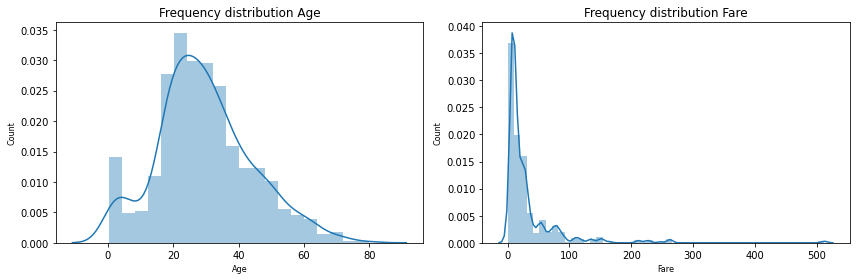

In [9]:
cont_cols = ['Age', 'Fare']
scols = 2
srows = 1
fig, axes = plt.subplots(srows, scols, figsize=(12,4))

for i, col in enumerate(cont_cols):
    ax_col = int(i%scols)
    ax_row = int(i/scols)
    print(f'{ax_col} {ax_row}')
    sns.distplot(train_df[col], ax=axes[ax_col])
    axes[ax_col].set_title(f'Frequency distribution {col}', fontsize=12)
    axes[ax_col].set_xlabel(col, fontsize=8)
    axes[ax_col].set_ylabel('Count', fontsize=8)
fig.tight_layout()
plt.show()

Both Age and Fare have right skewed distributions. We could also see this from the data displayed by the describe() function from earlier, but visuals are always better for checking out our data. 

For categorical variables, we use bar plots.

In [10]:
#what columnd we had, again ?
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:3

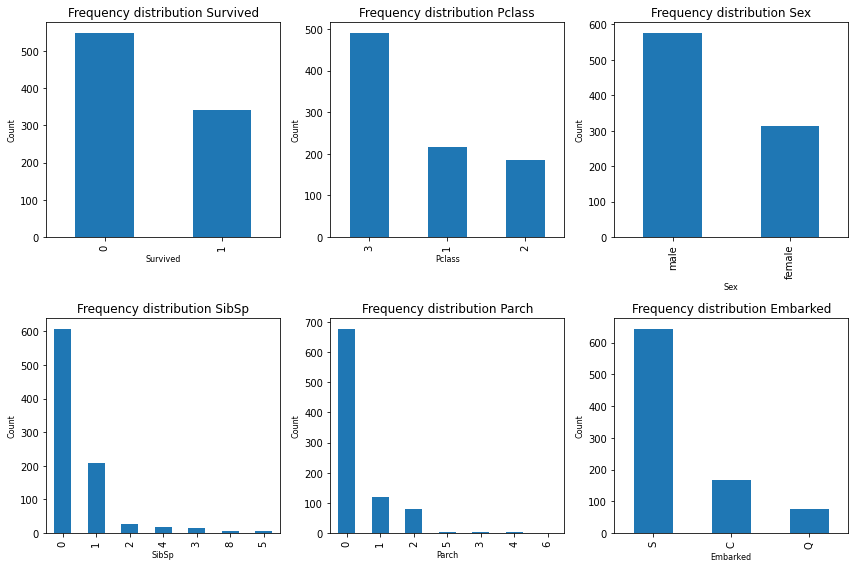

In [11]:
cat_cols = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

scols = 3
srows = 2

fig, axes = plt.subplots(srows, scols, figsize=(12,8))

for i, col in enumerate(cat_cols):
    ax_col = int(i%scols)
    ax_row = int(i/scols)
    #print(f'{ax_col} {ax_row}')
    #sns.barplot(train_df[col], ax=axes[ax_col])
    train_df[col].value_counts().plot(kind='bar', ax=axes[ax_row, ax_col])
    axes[ax_row, ax_col].set_title(f'Frequency distribution {col}', fontsize=12)
    axes[ax_row, ax_col].set_xlabel(col, fontsize=8)
    axes[ax_row, ax_col].set_ylabel('Count', fontsize=8)
fig.tight_layout()
plt.show()

Observations:  
- only 300 passengers survived
- half of our passengers are travelling in third class, one quarter in 1st and one quarter in 2nd
- we have twice as many males as females
- most passengers travel alone; 20% have 1 family member and very few of them have siblings or spouses
- we see the same pattern in the Parc (parents + cildren) variable
- over 600 travellers embarked in Southampton, ~150 in Cherbourg and <100 in Queenstown

 'Ticket', 'Cabin' have too many unique values for a bar chart to be meaningful.  
 Other columns we are going to ignore in our visualizatins: 'PassengerId', 'Name'

## 3. Data engineering

### 3.1 Title: engineering new feature

The Name column contains some more information besides just the name: it contains a title too. This title belongs into a separate feature instead of being embedded in a name variable. 

In [12]:
train_df['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

Extract the title for both dataset.

In [13]:
train_df['Title'] = train_df.Name.str.extract('(\w+)\.', expand=False)
test_df['Title'] = test_df.Name.str.extract('(\w+)\.', expand=False)

How many unique titles do we have ?

In [14]:
train_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

Does is make sense to have all of them as separate categories ?

In [15]:
train_df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Countess      1
Jonkheer      1
Lady          1
Sir           1
Capt          1
Don           1
Mme           1
Ms            1
Name: Title, dtype: int64

Some of them are extremely rare and it doesn't help us to keep them separate. It creates too many unnecessary categories. We will join all rare titles into a 'rare' category.  

Some titles are in French. We translate them to English (standardize our data).

In [16]:
combine = [train_df, test_df]
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [17]:
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


## 4. Missing data

In [18]:
print('Missing training data:\n',train_df.isnull().sum())
print('Missing test data:\n',test_df.isnull().sum())

Missing training data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64
Missing test data:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64


Missing data in training set:  
Age:            177  
Cabin:          687  
Embarked:         2

Missing data in test set:  
Age:             86  
Fare:             1  
Cabin:          327

The Cabin feature is missing to many data points. We will have to drop this feature from our datasets.

There are two options for dealing with missing data:  
- either dropping the data: either the rows with missing data (which we could do for Embarked, since it's only missing two values) or dropping the whole column (which we're going to do with Cabin, since it's missing way to many values to be still useful for further analysis)  
- or imputation: somehow inferring the most likely value. The imputed value can be the mean / median for the respective feature, or it can be computed through a more complex mechanism.

### 4.1 Age: impute missing value

**Acttion plan**  
* impute Age missing values

Training data: 177 samples are missing the Age value => we must impute Age (we cannot drop this amount of samples) We will use the same values to impute Age for test data too.

As mentioned previously, imputation can be as simple as using the mean of the feature for all missing values.  
But other feature could inform about the missing Age value. 

**Assumptions**
* There could be an interaction between Age and Title (for example, we expect someone with the title of 'Miss' to be younger than someone with the title of 'Mrs')
* There may be an interaction between Age and Pclass (we except an older person to travel in a higher class)
* We don't expect to see different mean Age for different point of Embarking, of course. 
* We do expect passengers of different Age to have different Parch (parents + children) or SibSp (siblings + spouses), as we expect older adults to have >=1 children or >= spouses, but given that the majority of our travellers have 0 Parch and 0 SibSp, we won't look into there two features.
- For a more accurate imputation, we will look at the mean age in passengers grouped by (Title,Pclass). We will use the mean age in each of these subgroups to replace missing values

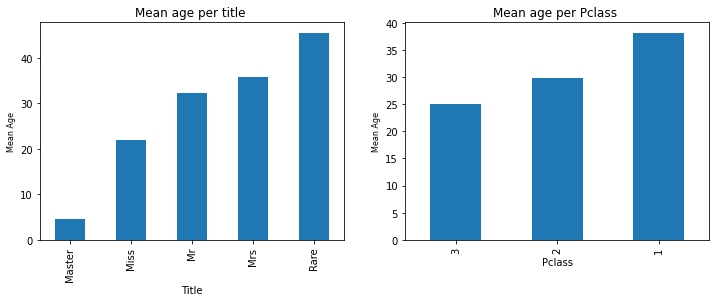

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

train_df.groupby('Title').Age.mean().sort_values(ascending=True).plot(kind='bar', ax=axes[0])
axes[0].set_title('Mean age per title ', fontsize=12)
axes[0].set_ylabel('Mean Age', fontsize=8)

train_df.groupby('Pclass').Age.mean().sort_values(ascending=True).plot(kind='bar', ax=axes[1])
axes[1].set_title('Mean age per Pclass ', fontsize=12)
axes[1].set_ylabel('Mean Age', fontsize=8)
plt.show()

In [20]:
# Group by title and for each title group by ticket class
# The assumption is that for the same title, people travelling in different classes have different mean age.
# Inspect data to confirm hypothesis
print('\nInspect mean Age in each subgroup\n')
print(pd.pivot_table(train_df, index=['Title', 'Pclass'], values=['Age'], aggfunc='mean'))


Inspect mean Age in each subgroup

                     Age
Title  Pclass           
Master 1        5.306667
       2        2.258889
       3        5.350833
Miss   1       29.744681
       2       22.560606
       3       16.123188
Mr     1       41.580460
       2       32.768293
       3       28.724891
Mrs    1       40.400000
       2       33.682927
       3       33.515152
Rare   1       47.571429
       2       42.000000


Before we proceed with imputation, let's make an observation. We notice in the table above that we have two subgroups with few datapoints (we have only 3 'Master' in first class, 9 in 2nd class and only 8 Rare tites in 2nd class). This means we would be using means of only 3, 9 or 8 datapoints.  

If we were to replace 100 missing values with the mean of 3 existing values, we could have a problem. Because these 3 values might be just spurious age values.  

To make sure we are not doing this mistake, we examine further.

In [21]:
print('-'*40)
# For the same grouping method as above, inspect data to make sure we will not infer data based on a sample too small
print('\nInspect number of Age data points in each subgroup.\nColumn Age now contains the number of data points in each subgroup.')
print(pd.pivot_table(train_df, index=['Title', 'Pclass'], values=['Age'], margins=False, aggfunc='count'))

print('-'*40)
# For the same grouping method as above, inspect data to make sure we will not infer data based on a sample too small
print('\nThe number of passengers in each subclass')
print(pd.pivot_table(train_df, index=['Title', 'Pclass'], values=['Name'], margins=False, aggfunc='count'))

----------------------------------------

Inspect number of Age data points in each subgroup.
Column Age now contains the number of data points in each subgroup.
               Age
Title  Pclass     
Master 1         3
       2         9
       3        24
Miss   1        47
       2        33
       3        69
Mr     1        87
       2        82
       3       229
Mrs    1        35
       2        41
       3        33
Rare   1        14
       2         8
----------------------------------------

The number of passengers in each subclass
               Name
Title  Pclass      
Master 1          3
       2          9
       3         28
Miss   1         48
       2         35
       3        102
Mr     1        107
       2         91
       3        319
Mrs    1         43
       2         41
       3         42
Rare   1         15
       2          8


The above tables show us that the number of data points in each of the small subgroups (Master in Pclass 1, Master in Pclass 2 and Rare in Pclass 2) is equal to the number of passengers in each subgroup. This means these subgroups are not missing any Age values, so we won't be needing the mean of these few data points for the imputation.

We can now proceed with the actual imputation of Age. We will use the mean of Title x Pclass subgroups to replace missing age values per passenger.  

Mind that **we use the subgroups means we obtain from the train data to replace missing values in test data**. This is always how we should proceed. Remember we are processing our data so we can feed it to classification models further. At the moment when we are building our model, we don't have test data yet (at least, we pretend we don't). Although test data is most of the time just regular training data that we take out from our original dataset and keep aside for later testing to measure our model fit (hence we call it test data), we do pretend like this data is actual test data that we obtain later in the future after we've built our model. So we can't use future information to infer missing values for past data. I hope this explanation makes sense to you.

In [22]:
# We conclude it is safe to replace missing age data with the mean of each subgroup so we proceed:
def fillAges(row):
    
    if row['Sex']=='female' and row['Pclass'] == 1:
        if row['Title'] == 'Miss':
            return 30
        if row['Title'] == 'Mrs':
            return 40
        elif row['Title'] == 'Rare':
            return 43

    elif row['Sex']=='female' and row['Pclass'] == 2:
        if row['Title'] == 'Miss':
            return 23
        elif row['Title'] == 'Mrs':
            return 34

    elif row['Sex']=='female' and row['Pclass'] == 3:
        
        if row['Title'] == 'Miss':
            return 16
        elif row['Title'] == 'Mrs':
            return 34

    elif row['Sex']=='male' and row['Pclass'] == 1:
        if row['Title'] == 'Master':
            return 5
        if row['Title'] == 'Mr':
            return 42
        elif row['Title'] == 'Rare':
            return 49

    elif row['Sex']=='male' and row['Pclass'] == 2:
        if row['Title'] == 'Master':
            return 2
        if row['Title'] == 'Mr':
            return 33
        if row['Title'] == 'Rare':
            return 42

    elif row['Sex']=='male' and row['Pclass'] == 3:
        if row['Title'] == 'Master':
            return 5
        elif row['Title'] == 'Mr':
            return 29

train_df_backup = train_df.copy()                
train_df['Age'] = train_df.apply(lambda s: fillAges(s) if np.isnan(s['Age']) else s['Age'], axis=1)

#use the same values means from train_data to replace the missing values in test_data
test_df_backup = test_df.copy()
test_df['Age'] = test_df.apply(lambda s: fillAges(s) if np.isnan(s['Age']) else s['Age'], axis=1)

**Examing Age distribution before and after imputation**  

I want to see if we produced noticeable changes in the data distribution through this imputation procedure. 

Text(0.5, 1.0, 'Test data')

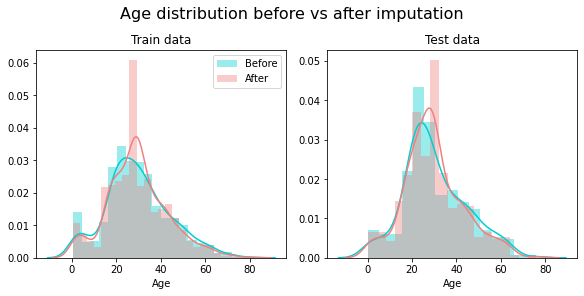

In [23]:
f, axes = plt.subplots(1, 2, constrained_layout = True, figsize = (8,4));
f.suptitle('Age distribution before vs after imputation', fontsize=16)
sns.distplot(train_df_backup.loc[~np.isnan(train_df_backup['Age']),'Age'], ax=axes[0], label='Before', color="darkturquoise")
sns.distplot(train_df['Age'], label='After', ax=axes[0], color="lightcoral")
axes[0].set_title(f'Train data', fontsize=12)
axes[0].legend()

sns.distplot(test_df_backup.loc[~np.isnan(test_df_backup['Age']),'Age'], ax=axes[1],  color="darkturquoise")
sns.distplot(test_df['Age'], ax=axes[1], color="lightcoral")
axes[1].set_title(f'Test data', fontsize=12)
#axes[1].legend()

The Age distribution looks similar before and after imputation for both train and test data. 

In [24]:
#let's free the memory from the backup dataset; we only needed it for the above plots
del train_df_backup
del test_df_backup

### 4.2 Cabin - examine later

As mentioned earlier, Cabin has too many missing value to be of use in further analysis.  
We can either drop it or change it into a binary variable, hasCabin, which can take the values 0 or 1.  
To decide which way to go, we will examine later the interaction with survival rates. 

### 4.3 Embarked - imputation

In [25]:
train_df.Embarked.isnull().sum()

2

--Frequency for point of embarkment--


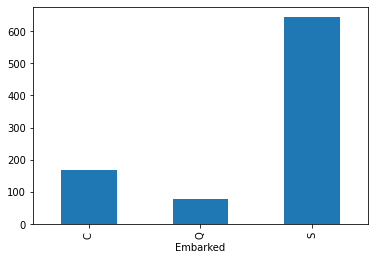

In [26]:
print("--Frequency for point of embarkment--")
train_df.groupby('Embarked').Embarked.count().plot(kind='bar', label='Frequency for point of embarkment')
plt.show();

**Decision:**  
**Impute S**  
Most of the people embarked in S, so our missing values will get the S value too.

In [27]:
#obtain the most common embarked value in an elegant way
freq_port = train_df.Embarked.dropna().mode()[0]

train_df['Embarked'] = train_df['Embarked'].fillna(freq_port)

### 4.4 Fare - imputation

We use the median to impute missing values for the continuous variable Fare.

In [28]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

Observation: of course, with just 2-3 values missing, we could have dropped those datapoints altogether without much effect on our results, given we have ~900 observation, but it would be a pity to throw away good data. 

## 5. Bivariate visualizations

In section 2 I plotted each feature individually.  
Now I want to see how different features vary together.  
I am still not looking at the dependent variable (the Survived feature), only at our independent variables.  
The reason I am doing this is that when I decide which features to select for building my prediction model, I will want to choose features who add new information, not two features that same more or less the same thing. And also because it will help us understand our data better.

In [29]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')

Pairplots (scatterplots) are useful when we have continuout variables. In our case, we only have 'PassengerId', 'Age', 'Fare'. I don't expect to see much correlation in the pairplots. In more wealthy societies, we'd expect that as people age they are gaining more money and they purchase more expensive tickets (in better class), but in Titanic's period and conditions, I don't think this was how things worked. 

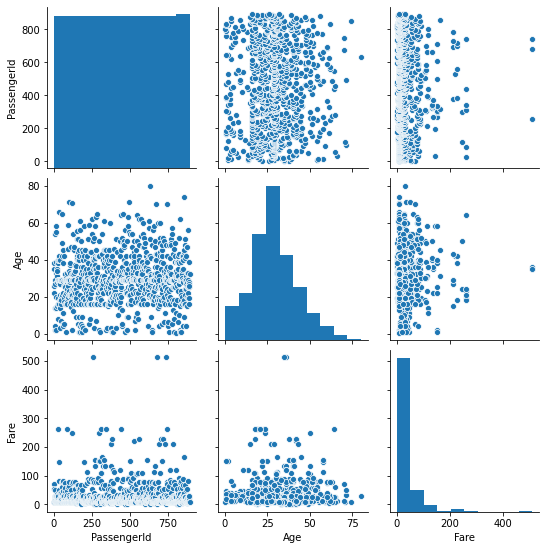

In [30]:
columns = ['PassengerId', 'Age', 'Fare']
sns.pairplot(train_df[columns])

## 6. Examining survival rates for different feature values

In [31]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')

### 6.1 Pclass and survival

Survival rates for each passenger class type: as expected, the better the class you are travelling in, the higher your chances or survival.

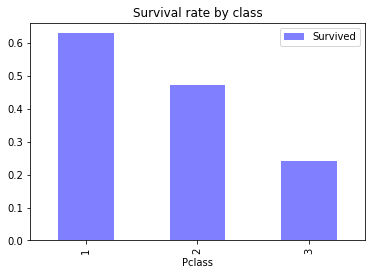

In [32]:
data_plot = train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
data_plot.plot.bar(x='Pclass', y='Survived', title='Survival rate by class', width=0.5, alpha = 0.5, color='b')
#.barchart(kind='bar', label='Survivors per class')

The plots above do show the information I wanted to see: how survival rates vary with class. But it doesn't look like the most intuitive way to visualize this information. I will try next to view the same info as stacked bar plots. I think this second method is more expressive, easier to 'read'.

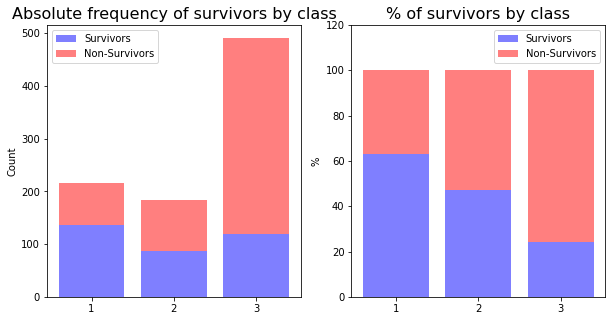

In [33]:
# calculate values for each survival status
survivors_class = train_df[train_df.Survived==True].groupby(['Pclass']).size().tolist()
non_survivors_class = train_df[train_df.Survived==False].groupby(['Pclass']).size().tolist()

survivors_relative = survivors_class / train_df.groupby(['Pclass']).size() * 100
non_survivors_relative = non_survivors_class / train_df.groupby(['Pclass']).size() * 100

xticks = train_df[train_df.Survived==True].groupby(['Pclass']).size().index.tolist()
xcoord = range(len(survivors_class))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

#plot absolute values by gender
ax1.bar(xcoord, survivors_class, label='Survivors', alpha=0.5, color='b')
ax1.bar(xcoord, non_survivors_class, bottom=survivors_class, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks(xcoord, xticks)
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Absolute frequency of survivors by class",fontsize=16)
plt.legend()

#plot relative values (%) by gender
ax2.bar(xcoord, survivors_relative, label='Survivors', alpha=0.5, color='b')
ax2.bar(xcoord, non_survivors_relative, bottom=survivors_relative, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks(xcoord, xticks)
plt.ylim(0, 120)
ax2.set_ylabel("%")
ax2.set_xlabel("")
ax2.set_title("% of survivors by class",fontsize=16)
plt.legend()

**Decisions**  
Consider **Pclass** for our prediction model.

### 6.2 Sex and survival

I look directly at stacked bar plots for survival rates by sex. 

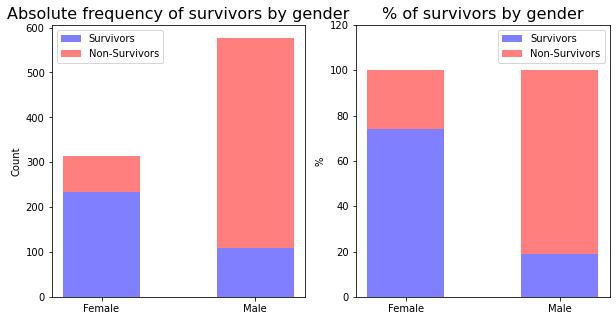

In [34]:
# calculate values for each survival status
survivors_gender = train_df[train_df.Survived==True].groupby(['Sex']).size().values
non_survivors_gender = train_df[train_df.Survived==False].groupby(['Sex']).size().values

survivors_relative = survivors_gender / [train_df.Sex.value_counts()['female'], train_df.Sex.value_counts()['male']] * 100
non_survivors_relative = non_survivors_gender / [train_df.Sex.value_counts()['female'], train_df.Sex.value_counts()['male']] * 100

# calculate totals for percentates
totals = survivors_gender + non_survivors_gender

xticks = ['Female', 'Male']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

#plot absolute values by gender
ax1.bar(range(len(survivors_gender)), survivors_gender, label='Survivors', alpha=0.5, color='b', width=.5)
ax1.bar(range(len(non_survivors_gender)), non_survivors_gender, bottom=survivors_gender, label='Non-Survivors', alpha=0.5, color='r', width=.5)
plt.sca(ax1)
plt.xticks([0, 1], xticks)
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Absolute frequency of survivors by gender",fontsize=16)
plt.legend()

#plot relative values (%) by gender
ax2.bar(range(len(survivors_gender)), survivors_relative, label='Survivors', alpha=0.5, color='b', width=.5)
ax2.bar(range(len(non_survivors_gender)), non_survivors_relative, bottom=survivors_relative, label='Non-Survivors', alpha=0.5, color='r', width=.5)
plt.sca(ax2)
plt.xticks([0, 1], xticks)
plt.ylim(0, 120)
ax2.set_ylabel("%")
ax2.set_xlabel("")
ax2.set_title("% of survivors by gender",fontsize=16)
plt.legend()

**Observations**  
We have almost double the number of men compared to women and women have ~70% survival rates, while men only ~20%. So sex seems like a strong predictor for chances of making it alive. 

**Decisions**  
Consider **Sex** for our prediction model.

### 6.3 Age and survival


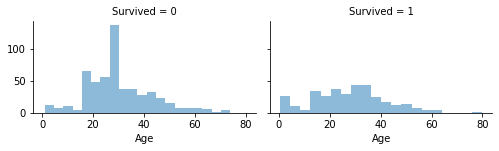

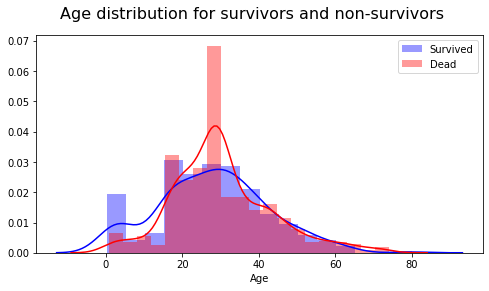

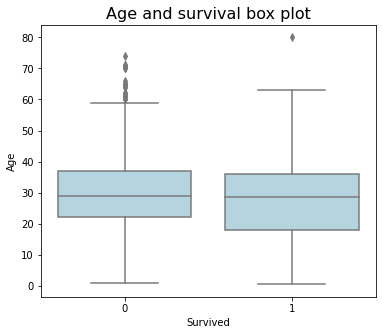

In [35]:
grid = sns.FacetGrid(train_df, col='Survived', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)

f, ax = plt.subplots();
f.set_size_inches(8,4)
f.suptitle('Age distribution for survivors and non-survivors', fontsize=16)
sns.distplot(train_df.loc[(train_df['Survived']==1) & (~np.isnan(train_df['Age'])),'Age'], label='Survived', color="b")
sns.distplot(train_df.loc[(train_df['Survived']==0) & (~np.isnan(train_df['Age'])),'Age'], label='Dead', color="r")
plt.legend()

plt.figure(figsize=(6,5))
plt.title('Age and survival box plot', fontsize=16)
sns.boxplot(x='Survived', y='Age', data=train_df, orient = 'v', color='lightblue')

Observations:
- children under 4 have higher survival rate
- somewhere around 30 years of age passengers have a very high mortality rate

**Decisions**  
Consider **Age** for our prediction model. However, the continuous age might be hiding patterns (if any exists). We can engineer a new feature: **AgeBin**, a categorical feature representing intervals of min and max age values.

**Survival rates for Age & Pclass**

First we check the interaction between Age and Pclass. It looks like as people get older, they tend to travel in a better class. It's interesting we didn't see this when we examined Age versus Fare. 

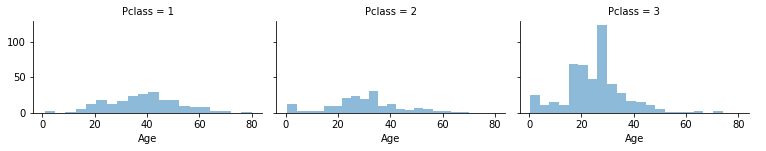

In [36]:
grid = sns.FacetGrid(train_df, col='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

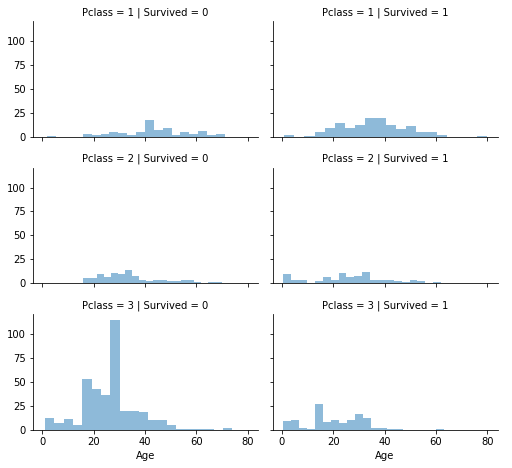

In [37]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

The above plot doesn't seem to bring new insights, but it was a good excuse to use FacetGrid, a nice tool in data visualization.

**Survival rates for Age & Sex**

First we check the interaction between Age and Pclass. It looks like as people get older, they tend to travel in a better class. It's interesting we didn't see this when we examined Age versus Fare. 

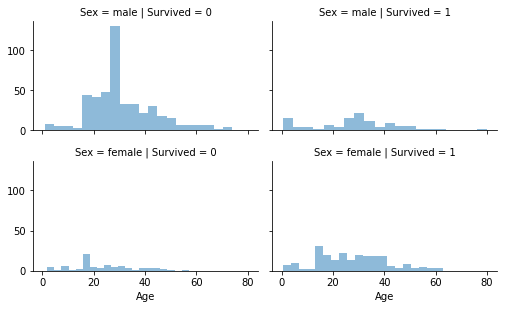

In [38]:
grid = sns.FacetGrid(train_df, col='Survived', row='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### 6.4 Family size (SibSp and Parch) and survival rates

In [39]:
# calculate values for each survival status
survivors_sibsp = train_df[train_df.Survived==True].groupby(['SibSp']).size()
#print(survivors_sibsp)
non_survivors_sibsp = train_df[train_df.Survived==False].groupby(['SibSp']).size()
#print(non_survivors_sibsp)

In [40]:
for i in range (5,9):
    survivors_sibsp = survivors_sibsp.set_value(i,0)
xcoord = survivors_sibsp.index.tolist()
survivors_sibsp = survivors_sibsp.tolist()
missing = pd.Series([0, 0], index=[6, 7])
non_survivors_sibsp = non_survivors_sibsp.append(missing).sort_index().tolist()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [41]:
sibsp_count = train_df.groupby(['SibSp']).size()
missing = pd.Series([0, 0], index=[6, 7])
sibsp_count = sibsp_count.append(missing).sort_index().tolist()
sibsp_count

[608, 209, 28, 16, 18, 5, 0, 0, 7]

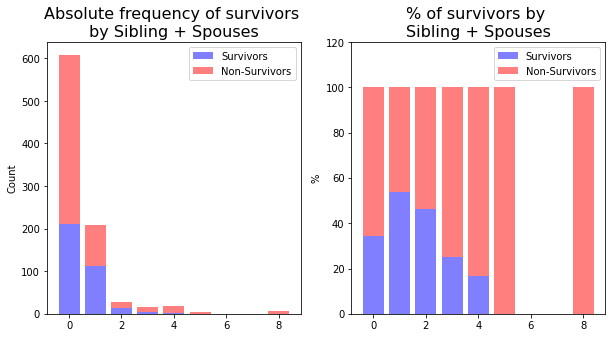

In [42]:
#List comphrehension with test to avoid division by zero
survivors_relative = [x/y * 100 if y else 0 for x, y in zip(survivors_sibsp, sibsp_count)]
non_survivors_relative = [x/y * 100 if y else 0 for x, y in zip(non_survivors_sibsp, sibsp_count)]

xcoord = range(len(survivors_sibsp))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

#plot absolute values by gender
ax1.bar(xcoord, survivors_sibsp, label='Survivors', alpha=0.5, color='b')
ax1.bar(xcoord, non_survivors_sibsp, bottom=survivors_sibsp, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
#plt.xticks(xcoord, xticks)
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Absolute frequency of survivors \nby Sibling + Spouses",fontsize=16)
plt.legend()

#plot relative values (%) by gender
ax2.bar(xcoord, survivors_relative, label='Survivors', alpha=0.5, color='b')
ax2.bar(xcoord, non_survivors_relative, bottom=survivors_relative, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax2)
#plt.xticks(xcoord, xticks)
plt.ylim(0, 120)
ax2.set_ylabel("%")
ax2.set_xlabel("")
ax2.set_title("% of survivors by \nSibling + Spouses",fontsize=16)
plt.legend()

**Parch**

In [43]:
# calculate values for each survival status
survivors_parch = train_df[train_df.Survived==True].groupby(['Parch']).size()
non_survivors_parch = train_df[train_df.Survived==False].groupby(['Parch']).size()

In [44]:
missing = pd.Series([0, 0], index=[4, 6])
survivors_parch = survivors_parch.append(missing).sort_index().tolist()

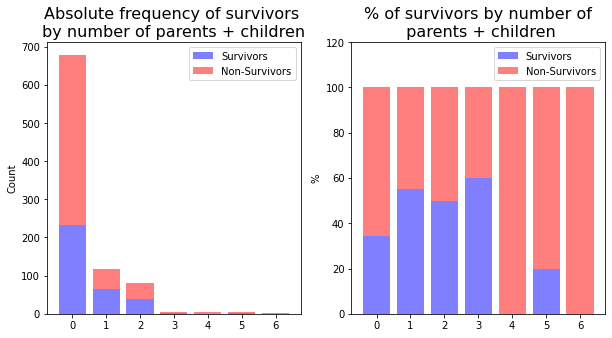

In [45]:
parch_count = train_df.groupby(['Parch']).size()

#List comphrehension with test to avoid division by zero
survivors_relative = [x/y * 100 if y else 0 for x, y in zip(survivors_parch, parch_count)]
non_survivors_relative = [x/y * 100 if y else 0 for x, y in zip(non_survivors_parch, parch_count)]

xcoord = range(len(survivors_parch))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

#plot absolute values by gender
ax1.bar(xcoord, survivors_parch, label='Survivors', alpha=0.5, color='b')
ax1.bar(xcoord, non_survivors_parch, bottom=survivors_parch, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
#plt.xticks(xcoord, xticks)
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Absolute frequency of survivors \nby number of parents + children",fontsize=16)
plt.legend()

#plot relative values (%) by gender
ax2.bar(xcoord, survivors_relative, label='Survivors', alpha=0.5, color='b')
ax2.bar(xcoord, non_survivors_relative, bottom=survivors_relative, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax2)
#plt.xticks(xcoord, xticks)
plt.ylim(0, 120)
ax2.set_ylabel("%")
ax2.set_xlabel("")
ax2.set_title("% of survivors by number of\n parents + children",fontsize=16)
plt.legend()

There seems to be an ideal family size for maximizing one's rates of survival. If you're alone or if you're family is large, there is a higher chance to die. 

**Decisions**  
Instead of keeping both Parch and SibSp, we will engineer a new feature: FamilySize. A categorical feature with possible values: 
- alone
- small
- large

### 6.5 Fare and survival chances

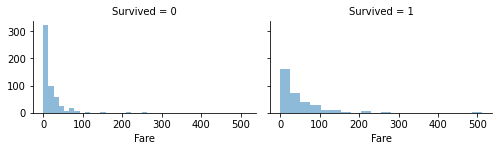

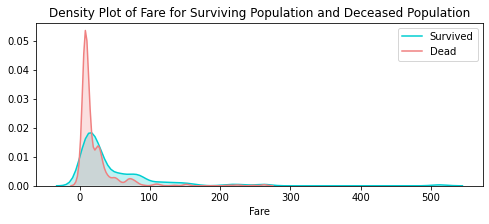

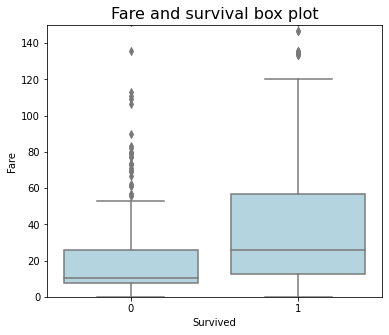

In [46]:
grid = sns.FacetGrid(train_df, col='Survived', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Fare', alpha=.5, bins=20)

plt.show();

plt.figure(figsize=(8,3))
ax = sns.kdeplot(train_df[train_df['Survived']==1]['Fare'], color="darkturquoise", shade=True)
sns.kdeplot(train_df[train_df['Survived']==0]['Fare'], color="lightcoral", shade=True)
plt.legend(['Survived', 'Dead'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.show()

plt.figure(figsize=(6,5))
plt.title('Fare and survival box plot', fontsize=16)
plt.ylim(0, 150)
sns.boxplot(x='Survived', y='Fare', data=train_df, orient = 'v', color='lightblue')

We notice people with cheapest tickets have highest death rates. This is most likely the same thing we've seen when we examined Pclass and Survival: 3rd class passengers had lowest survival chances. 

**Decision**  
Fare seems too granular though. It might be better to bin it into fare intervals and convert it into a categorical variable (next section).

### 6.6 Cabin and survival

Cabin is missing from 687 passengers in the train set and 327 in the test set.  
Before we can examine survival rates versus Cabin, we need to perform some more feature engineering: create a new feature hasCabin and encode as 1/0 (has cabin value / is missing cabin value).

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object


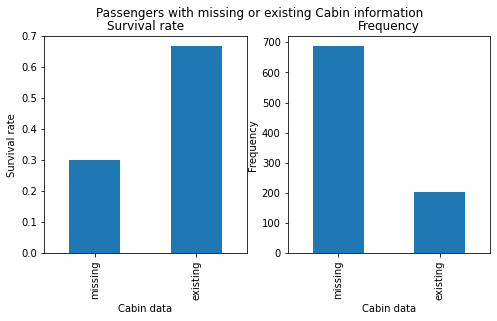

In [47]:
print(train_df['Cabin'].describe())

combine = [train_df, test_df]
for dataset in combine:
    dataset.loc[pd.isna(train_df['Cabin']), 'hasCabin'] = 0
    dataset.loc[train_df['hasCabin']!=0,'hasCabin'] = 1
    dataset.hasCabin = dataset.hasCabin.astype(int)

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
f.suptitle('Passengers with missing or existing Cabin information')

s = pd.Series(["missing","existing"]);

train_df.groupby('hasCabin').Survived.mean().plot(kind='bar', ax=axes[0], title="Survival rate")
axes[0].set_xticklabels(s)
axes[0].set_xlabel('Cabin data');
axes[0].set_ylabel('Survival rate');

train_df.groupby('hasCabin').Name.count().plot(kind='bar', ax=axes[1], title="Frequency")
axes[1].set_xticklabels(s)
axes[1].set_xlabel('Cabin data');
axes[1].set_ylabel('Frequency');

In [48]:
train_df[train_df.Survived==True].groupby(['hasCabin']).size()

hasCabin
0    206
1    136
dtype: int64

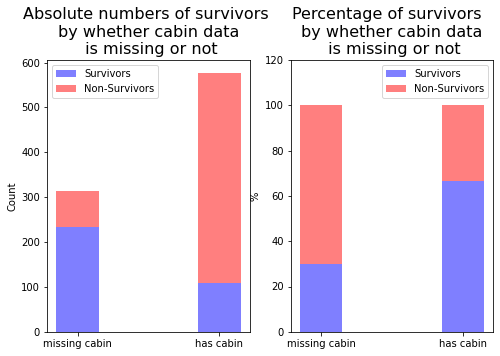

In [49]:
# calculate values for each survival status
survivors_cabin = train_df[train_df.Survived==True].groupby(['hasCabin']).size().values
non_survivors_cabin = train_df[train_df.Survived==False].groupby(['hasCabin']).size().values

# calculate totals 
totals = survivors_cabin + non_survivors_cabin

#survivors_relative = survivors_cabin / [train_df.hasCabin.value_counts()[0], train_df.hasCabin.value_counts()[1]] * 100
#non_survivors_relative = non_survivors_cabin / [train_df.hasCabin.value_counts()[0], train_df.hasCabin.value_counts()[1]] * 100

survivors_relative = survivors_cabin / totals * 100
non_survivors_relative = non_survivors_cabin / totals * 100

xticks = ['missing cabin', 'has cabin']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))

#plot absolute values by gender
ax1.bar(range(len(survivors_gender)), survivors_gender, label='Survivors', alpha=0.5, color='b', width=.3)
ax1.bar(range(len(non_survivors_gender)), non_survivors_gender, bottom=survivors_gender, label='Non-Survivors', alpha=0.5, color='r', width=.3)
plt.sca(ax1)
plt.xticks([0, 1], xticks)
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Absolute numbers of survivors \nby whether cabin data\n is missing or not",fontsize=16)
plt.legend()

#plot relative values (%) by gender
ax2.bar(range(len(survivors_gender)), survivors_relative, label='Survivors', alpha=0.5, color='b', width=.3)
ax2.bar(range(len(non_survivors_gender)), non_survivors_relative, bottom=survivors_relative, label='Non-Survivors', alpha=0.5, color='r', width=.3)
plt.sca(ax2)
plt.xticks([0, 1], xticks)
plt.ylim(0, 120)
ax2.set_ylabel("%")
ax2.set_xlabel("")
ax2.set_title("Percentage of survivors  \nby whether cabin data\n is missing or not",fontsize=16)
plt.legend()

**Observations:**  
* those that have the cabin information have way higher survival rates than the ones with missing cabin data

**Conclusion**  
Keep **hasCabin** for training classification models

### 6.7 Embarked and survival chances

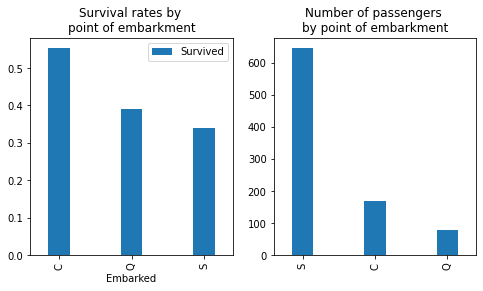

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].set_title('Survival rates by \npoint of embarkment', fontsize=12)
data_plot = train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)
data_plot.plot.bar(x='Embarked', y='Survived', ax = axes[0], width=0.3)

axes[1].set_title('Number of passengers \nby point of embarkment', fontsize=12)
train_df.Embarked.value_counts().sort_values(ascending=False).plot.bar(ax = axes[1], width=0.3)

plt.show()

Observations:
- most passengers embarked Southampton
- Southampton has lowest survival rates
- best suvival rates for travelers embarked in Cherbourg 

**Decision**
Consider Embarked for model training.

### 6.8 Title and survival

In [51]:
train_df[train_df.Survived==True].groupby(['Title']).size()

Title
Master     23
Miss      130
Mr         81
Mrs       100
Rare        8
dtype: int64

In [52]:
train_df.groupby(['Title']).size().index.tolist()

['Master', 'Miss', 'Mr', 'Mrs', 'Rare']

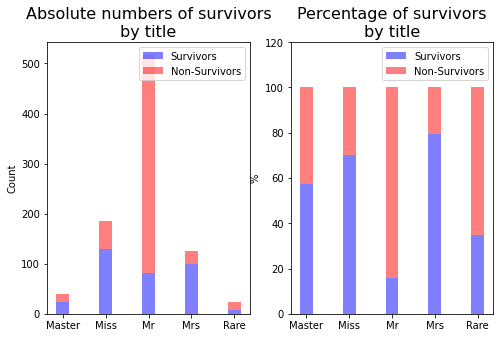

In [53]:
# calculate values for each survival status
survivors_title = train_df[train_df.Survived==True].groupby(['Title']).size().values
non_survivors_title = train_df[train_df.Survived==False].groupby(['Title']).size().values

# calculate totals 
totals = survivors_title + non_survivors_title

survivors_relative = survivors_title / totals * 100
non_survivors_relative = non_survivors_title / totals * 100

xticks = train_df.groupby(['Title']).size().index.tolist()
xcoord = range(len(survivors_title))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))

#plot absolute values by title
ax1.bar(xcoord, survivors_title, label='Survivors', alpha=0.5, color='b', width=.3)
ax1.bar(xcoord, non_survivors_title, bottom=survivors_title, label='Non-Survivors', alpha=0.5, color='r', width=.3)
plt.sca(ax1)
plt.xticks(xcoord, xticks)
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Absolute numbers of survivors\nby title",fontsize=16)
plt.legend()

#plot relative values (%) by title
ax2.bar(xcoord, survivors_relative, label='Survivors', alpha=0.5, color='b', width=.3)
ax2.bar(xcoord, non_survivors_relative, bottom=survivors_relative, label='Non-Survivors', alpha=0.5, color='r', width=.3)
plt.sca(ax2)
plt.xticks(xcoord, xticks)
plt.ylim(0, 120)
ax2.set_ylabel("%")
ax2.set_xlabel("")
ax2.set_title("Percentage of survivors\nby title",fontsize=16)
plt.legend()

Observations:
- highest survival rates for women (Mrs and Miss) and then for boys (Master)
- this seems to confirm the interaction we've seen earlier between Age, Sex and Survival.  
We will keep Title for training our model.  
It's interesting also that some of its categories are encoding both sex and age (e.g. Master is a title for small boys).

## 7. More feature engineering

### 7.1 AgeBins

We split Age into 5 equal intervals for the training data. We use the same intervals to split passangers by age in the test data.  
This way we engineer a new categorical feature: **AgeBins**

In [54]:
train_df['AgeBins'] = pd.cut(train_df['Age'], 5, precision=0)

bins = [0.0, 16.0, 32.0, 48.0, 64.0, 80.0]
test_df['AgeBins'] = pd.cut(test_df['Age'], bins, precision=0)

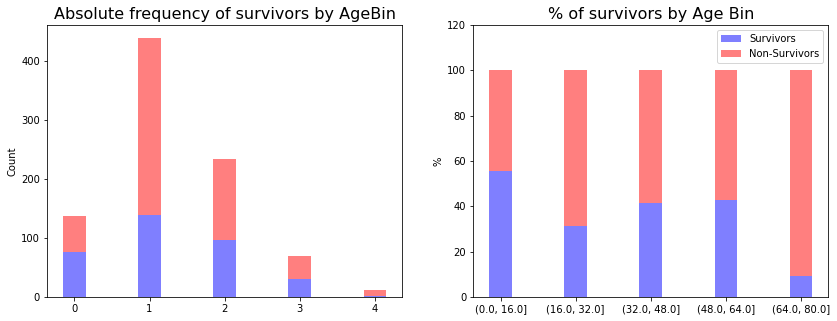

In [55]:
# calculate values for each survival status
survivors_age = train_df[train_df.Survived==True].groupby(['AgeBins']).size().tolist()
non_survivors_age = train_df[train_df.Survived==False].groupby(['AgeBins']).size().tolist()

survivors_relative = survivors_age / train_df.groupby(['AgeBins']).size() * 100
non_survivors_relative = non_survivors_age / train_df.groupby(['AgeBins']).size() * 100

xticks = train_df[train_df.Survived==True].groupby(['AgeBins']).size().index.tolist()
xcoord = range(len(survivors_age))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

#plot absolute values of survival by AgeBin
ax1.bar(xcoord, survivors_age, label='Survivors', alpha=0.5, color='b', width=.3)
ax1.bar(xcoord, non_survivors_age, bottom=survivors_age, label='Non-Survivors', alpha=0.5, color='r', width=.3)
plt.sca(ax2)
plt.xticks(xcoord, xticks)
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Absolute frequency of survivors by AgeBin",fontsize=16)
plt.legend()

#plot % values of survival by AgeBin
ax2.bar(xcoord, survivors_relative, label='Survivors', alpha=0.5, color='b', width=.3)
ax2.bar(xcoord, non_survivors_relative, bottom=survivors_relative, label='Non-Survivors', alpha=0.5, color='r', width=.3)
plt.xticks(xcoord, xticks)
plt.ylim(0, 120)
ax2.set_ylabel("%")
ax2.set_xlabel("")
ax2.set_title("% of survivors by Age Bin",fontsize=16)
plt.legend()

**Observations:**
- children have highest chances of survival
- there's a drop around ~ age 30, as noticed earlier
- then survival rates increase after 32 years of age
- and then old age gives lowest survival rates.

**Decision**  
Keep both Age and AgeBins and decide which one to use depending on the model we choose and whether it works better with numerical or categorical data.  
However, from the look of these plot, age is probably not a strong predictor of survival chances.

### 7.2 FamilySize

Add SibSp and Parch to create FamilySize and examine survival rates.

--Survival Rate for FamilySize--


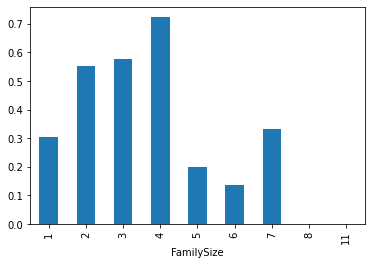

--Frequency for FamilySize--


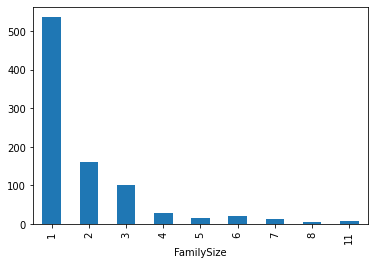

In [56]:
combine = [train_df, test_df]

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

print("--Survival Rate for FamilySize--")
train_df.groupby('FamilySize').Survived.mean().plot(kind='bar')
plt.show();

print("--Frequency for FamilySize--")
train_df.groupby('FamilySize').FamilySize.count().plot(kind='bar')
plt.show();

**Observations:**
* if you're alone, you have lower survival rate than families of 2,3 or 4
* but large families (from 5 onwards) have lower rates

**Decisions:**  
* Transform FamilySize into a categorical feature with three values: alone / small / large

In [57]:
def encode_family(size):
    if size==1:
        return 'alone'
    if size<5:
        return 'small'
    return 'large'
    
for dataset in combine:
    dataset['FamilySize'] = dataset['FamilySize'].apply(lambda x: encode_family(x))

--Survival rate for new FamilySize--


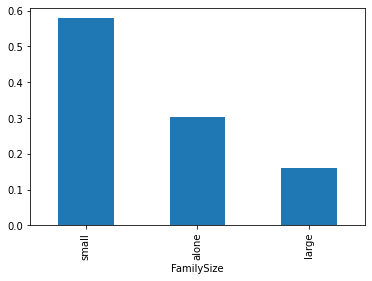

In [58]:
print("--Survival rate for new FamilySize--")
train_df.groupby('FamilySize').Survived.mean().sort_values(ascending=False).plot(kind='bar')
plt.show();

**Decision**  
Keep FamilySize categorical feature for model training and drop SibSp and Parch.

### 7.3 FareBins

Let's see how to split Fare into bins. It might be the case that equal bins don't make sense here. That's because Fare spreads on a wide interval and at the same time it's not normally distributed.  
From the plot below it looks like most of the action is happening between 0 and 100.

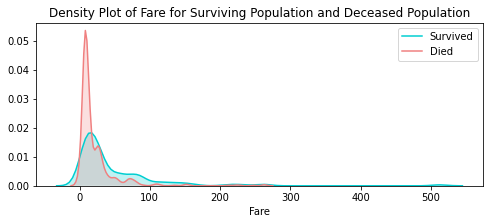

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


In [59]:
plt.figure(figsize=(8,3))
ax = sns.kdeplot(train_df[train_df['Survived']==1]['Fare'], color="darkturquoise", shade=True) 
sns.kdeplot(train_df[train_df['Survived']==0]['Fare'], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.show()

print(train_df['Fare'].describe())

I will take the semi-arbitrary decision to split the 0 to max(Fare) interval by the following division points: 20, 40, 80.  

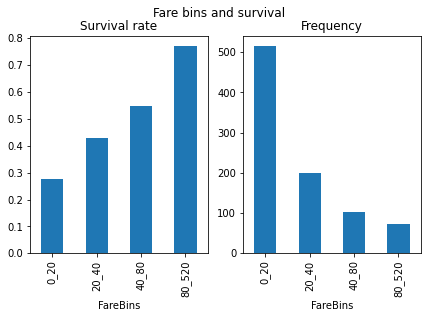

In [60]:
train_df.loc[train_df['Fare']<=20,'FareBins']='0_20'     
train_df.loc[(train_df['Fare']>20)&(train_df['Fare']<=40),'FareBins']='20_40' 
train_df.loc[(train_df['Fare']>40)&(train_df['Fare']<=80),'FareBins']='40_80' 
train_df.loc[train_df['Fare']>80,'FareBins']='80_520'

test_df.loc[test_df['Fare']<=20,'FareBin']='0_20'     
test_df.loc[(test_df['Fare']>20)&(test_df['Fare']<=40),'FareBins']='20_40' 
test_df.loc[(test_df['Fare']>40)&(test_df['Fare']<=80),'FareBins']='40_80' 
test_df.loc[test_df['Fare']>80,'FareBins']='80_520'

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,4))
f.suptitle('Fare bins and survival')
train_df.groupby('FareBins').Survived.mean().plot(kind='bar', ax=axes[0], title="Survival rate")
train_df.groupby('FareBins').Name.count().plot(kind='bar', ax=axes[1], title="Frequency")

**Decision**  
Keep both Fare and FareBins and decide which one to use depending on the model we choose and whether it works better with numerical or categorical data.

## 7. Removing unnecessary data

In [61]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'hasCabin',
       'AgeBins', 'FamilySize', 'FareBins'],
      dtype='object')

In [62]:
#we will keep Age and Fare. At this point, as we 
columns_to_remove = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin']

train_df.drop(columns_to_remove, axis=1, inplace=True)
test_df.drop(columns_to_remove, axis=1, inplace=True)

## 8. Encoding categorical variables

Most algorithms (except for Decision Trees, for example) ony accept numerical values for input. 

In [63]:
train_df.head(1)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,hasCabin,AgeBins,FamilySize,FareBins
0,0,3,male,22.0,7.25,S,Mr,0,"(16.0, 32.0]",small,0_20


So we have Sex, Embarked, Title, AgeBins, FamilySize and FareBins that we need to encode to numerical values.

In [64]:
combine = [train_df, test_df]

sex_mapping = {'female': 1, 'male': 0}
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
age_mapping = {pd.Interval(left=0.0, right=16.0): 1, pd.Interval(left=16.0, right=32.0): 2, pd.Interval(left=32.0, right=48.0): 3, pd.Interval(left=48.0, right=64.0): 4, pd.Interval(left=64.0, right=80.0): 5}
family_mapping = {'alone': 0, 'small': 1, 'large': 2}
fare_mapping = {'0_20': 1, '20_40': 2, '40_80': 3, '80_520': 4}
train_df.head()

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping).astype(int)
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['AgeBins'] = dataset['AgeBins'].map(age_mapping)
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)
    dataset['FareBins'] = dataset['FareBins'].map(fare_mapping)

And we're done. Let's have a quick look at our data one last time:

In [65]:
train_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,hasCabin,AgeBins,FamilySize,FareBins
0,0,3,0,22.0,7.2500,0,1,0,2,1,1
1,1,1,1,38.0,71.2833,1,3,1,3,1,3
2,1,3,1,26.0,7.9250,0,2,0,2,0,1


We're ready to start building models to classify our data. In another Notebook, since this one became too large already.